<a href="https://colab.research.google.com/github/SarkarPriyanshu/CarInsuanceClaim/blob/main/Insurance_Domain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# BUSINESS PROBLEM STATEMENT

- Develop a predictive model that assesses the claim probability for car insurance policies. The objective would be to understand the factors that influence claim frequency and severity in the period of six months and enable insurance companies to better assess risk and determine appropriate premiums for policyholders.


In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option('display.max_columns', None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from google.colab import drive
drive.mount('/content/gdrivr')

Mounted at /content/gdrivr


In [2]:
# policy_id is personal identifiable information hence dropped
df = pd.read_csv('/content/gdrivr/MyDrive/DataSets/Data.csv').drop('policy_id',axis=1)

# Basic Analysis

In [3]:
# data dimension
df.shape

(58592, 43)

In [4]:
# how data looks
df.head()

,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
1,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
2,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
3,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,1.2 L K12N Dualjet,2,Yes,Yes,No,Yes,Yes,Drum,1197,4,Automatic,5,Electric,4.8,3995,1735,1515,1335,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,1.0 SCe,2,No,No,No,No,Yes,Drum,999,3,Automatic,5,Electric,5.0,3731,1579,1490,1155,No,No,No,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0


In [5]:
# null values per feature
(df.isna().sum()/df.shape[0] * 100).reset_index().rename(columns={'index':'Features',0:'Null value %'})

,Features,Null value %
0,policy_tenure,0.0
1,age_of_car,0.0
2,age_of_policyholder,0.0
3,area_cluster,0.0
4,population_density,0.0
5,make,0.0
6,segment,0.0
7,model,0.0
8,fuel_type,0.0
9,max_torque,0.0


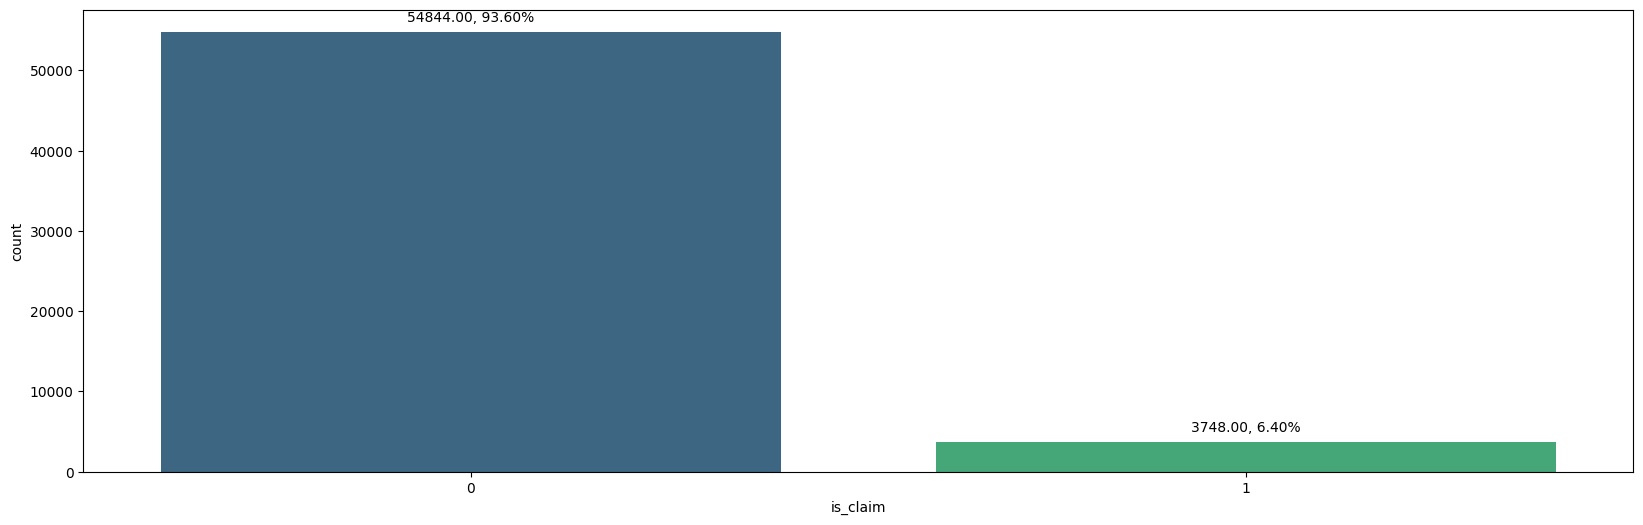

In [6]:
#target features balance or imbalance.

plt.figure(figsize=(20,6))
count = sns.countplot(data=df,x='is_claim',palette='viridis',)
for p in count.patches:
  count.annotate(f'{format(p.get_height(), ".2f")}, {format(p.get_height()/df.shape[0] * 100,".2f")}%' , (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha = 'center', va = 'center',
                 xytext = (0, 10),
                 textcoords = 'offset points')
plt.show()

In [7]:
# dtypes of features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_tenure                     58592 non-null  float64
 1   age_of_car                        58592 non-null  float64
 2   age_of_policyholder               58592 non-null  float64
 3   area_cluster                      58592 non-null  object 
 4   population_density                58592 non-null  int64  
 5   make                              58592 non-null  int64  
 6   segment                           58592 non-null  object 
 7   model                             58592 non-null  object 
 8   fuel_type                         58592 non-null  object 
 9   max_torque                        58592 non-null  object 
 10  max_power                         58592 non-null  object 
 11  engine_type                       58592 non-null  object 
 12  airb

In [8]:
# descriptive analysis of numeric features
df.select_dtypes(exclude='object').describe().T

,count,mean,std,min,25%,50%,75%,max
policy_tenure,58592.0,0.611246,0.414156,0.002735,0.210250,0.573792,1.039104,1.396641
age_of_car,58592.0,0.069424,0.056721,0.000000,0.020000,0.060000,0.110000,1.000000
age_of_policyholder,58592.0,0.469420,0.122886,0.288462,0.365385,0.451923,0.548077,1.000000
population_density,58592.0,18826.858667,17660.174792,290.000000,6112.000000,8794.000000,27003.000000,73430.000000
make,58592.0,1.763722,1.136988,1.000000,1.000000,1.000000,3.000000,5.000000
airbags,58592.0,3.137066,1.832641,1.000000,2.000000,2.000000,6.000000,6.000000
displacement,58592.0,1162.355851,266.304786,796.000000,796.000000,1197.000000,1493.000000,1498.000000
cylinder,58592.0,3.626963,0.483616,3.000000,3.000000,4.000000,4.000000,4.000000
gear_box,58592.0,5.245443,0.430353,5.000000,5.000000,5.000000,5.000000,6.000000
turning_radius,58592.0,4.852893,0.228061,4.500000,4.600000,4.800000,5.000000,5.200000


In [9]:
# descriptive analysis of categorical features
df.select_dtypes(include='object').describe().T

,count,unique,top,freq
area_cluster,58592,22,C8,13654
segment,58592,6,B2,18314
model,58592,11,M1,14948
fuel_type,58592,3,Petrol,20532
max_torque,58592,9,113Nm@4400rpm,17796
max_power,58592,9,88.50bhp@6000rpm,17796
engine_type,58592,11,F8D Petrol Engine,14948
is_esc,58592,2,No,40191
is_adjustable_steering,58592,2,Yes,35526
is_tpms,58592,2,No,44574


In [10]:
# do we have any duplicate observations
df.duplicated().sum()

0

In [11]:
# This function feteh the numerical values from sentence (both descrete and continues)
def getNm(string):
  pattern = r'\d+\.*\d+'
  pattern = re.compile(pattern,re.IGNORECASE)
  return re.findall(pattern,string)[0]

# This function feteh the numerical values from sentence (both descrete and continues)
def getTorque(string):
  pattern = r'\d+\.*\d+'
  pattern = re.compile(pattern,re.IGNORECASE)
  return re.findall(pattern,string)[1]

# This piece of code tranforms various features
df = df.assign(
    max_torque_nm = df['max_torque'].apply(getNm), #fetch numerical values
    max_torque_torque = df['max_torque'].apply(getTorque), #fetch numerical values
    max_power_nm = df['max_power'].apply(getNm,), #fetch numerical values
    max_power_torque = df['max_power'].apply(getTorque), #fetch numerical values
    age_of_car = df['age_of_car'].apply(lambda x:int(x*100)), #convert to descrete from continues
    age_of_policyholder = df['age_of_policyholder'].apply(lambda x:int(x*100))  #convert to descrete from continues

)

#convert to dtype of features
df = df.astype({'max_torque_nm':'float32',
                'max_torque_torque':'int32',
                'max_power_torque':'int32',
                'max_power_nm':'float32',
                'cylinder':'int32',
                'gear_box':'int32'
                })

# dropping unnecessory columns
df.drop(['max_torque','max_power'],axis=1,inplace=True)

df.head()

,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim,max_torque_nm,max_torque_torque,max_power_nm,max_power_torque
0,0.515874,5,64,C1,4990,1,A,M1,CNG,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0,60.0,3500,40.360001,6000
1,0.672619,2,37,C2,27003,1,A,M1,CNG,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0,60.0,3500,40.360001,6000
2,0.841110,2,38,C3,4076,1,A,M1,CNG,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0,60.0,3500,40.360001,6000
3,0.900277,11,43,C4,21622,1,C1,M2,Petrol,1.2 L K12N Dualjet,2,Yes,Yes,No,Yes,Yes,Drum,1197,4,Automatic,5,Electric,4.8,3995,1735,1515,1335,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0,113.0,4400,88.500000,6000
4,0.596403,11,63,C5,34738,2,A,M3,Petrol,1.0 SCe,2,No,No,No,No,Yes,Drum,999,3,Automatic,5,Electric,5.0,3731,1579,1490,1155,No,No,No,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0,91.0,4250,67.059998,5500


# EDA

In [12]:
# Seperating feature based on there data type
continues_feature = list()
descrete_feature = list()
categorical_feature = list()
cardinal_feature = list()

target_feature = None

# variables that store feature importance
features_to_drop = list()
features_to_select = list()


for feature in df.select_dtypes(exclude='object').columns.to_list():
  if feature == 'is_claim':
    target_feature = feature
  else:
      if df[feature].nunique() > 10:
        continues_feature.append(feature)
      else:
        descrete_feature.append(feature)

for feature in df.select_dtypes(include='object').columns.to_list():
   if feature == 'is_claim':
    target_feature = feature
   else:
      if df[feature].nunique() > 10:
        cardinal_feature.append(feature)
      else:
        categorical_feature.append(feature)

print('Continues features counts:',len(continues_feature))
print('Descrete features counts:',len(descrete_feature))
print('Categorical features counts:',len(categorical_feature))
print('High cardianlity features counts:',len(cardinal_feature))

Continues features counts: 5
Descrete features counts: 14
Categorical features counts: 22
High cardianlity features counts: 3


## Univariant Analysis


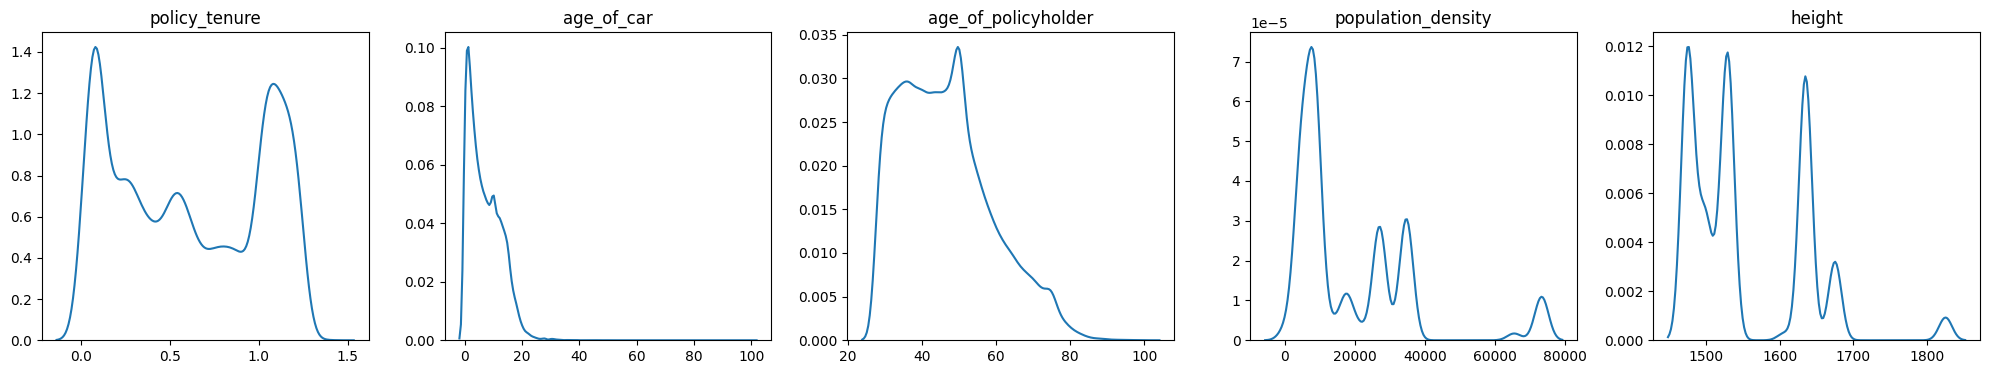

In [13]:
# Show kde plot of continues feature
fig,axes = plt.subplots(1,5,figsize=(20,4))
for col,ax in zip(continues_feature,axes.flatten()):
  sns.kdeplot(data=df,x=col,ax=ax)
  ax.set_title(col)
  ax.set_xlabel('')
  ax.set_ylabel('')

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

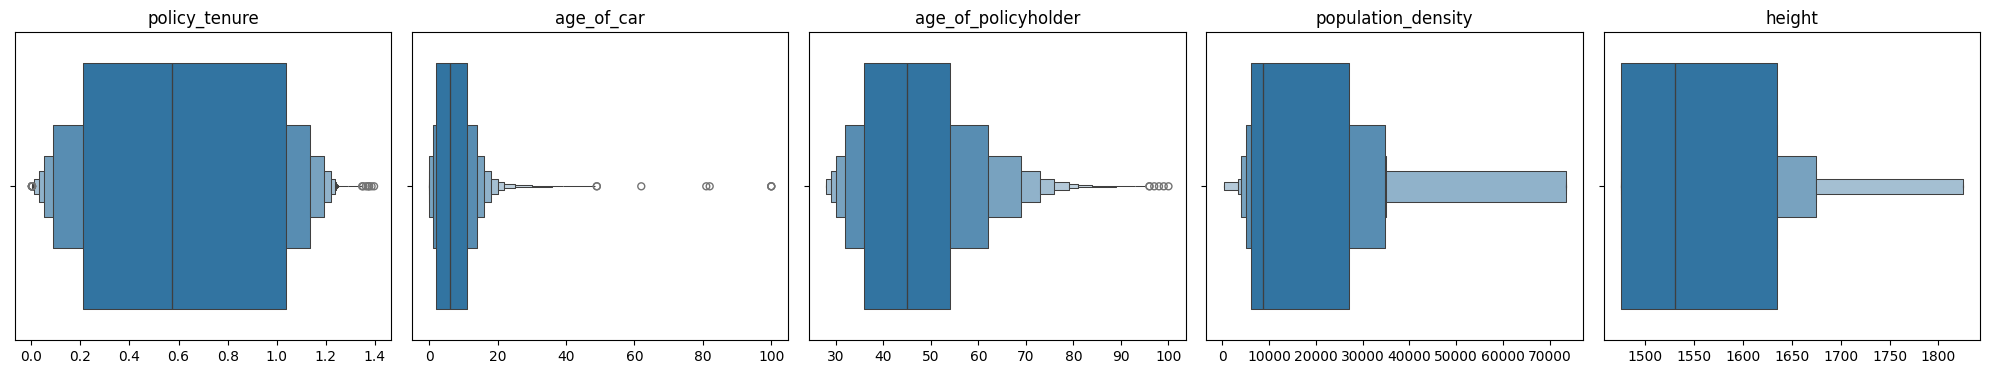

In [14]:
# Show boxplot plot of continues feature to check outliers
fig,axes = plt.subplots(1,5,figsize=(20,4))
for col,ax in zip(continues_feature,axes.flatten()):
  sns.boxenplot(data=df,x=col,ax=ax)
  ax.set_title(col)
  ax.set_xlabel('')
  ax.set_ylabel('')

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

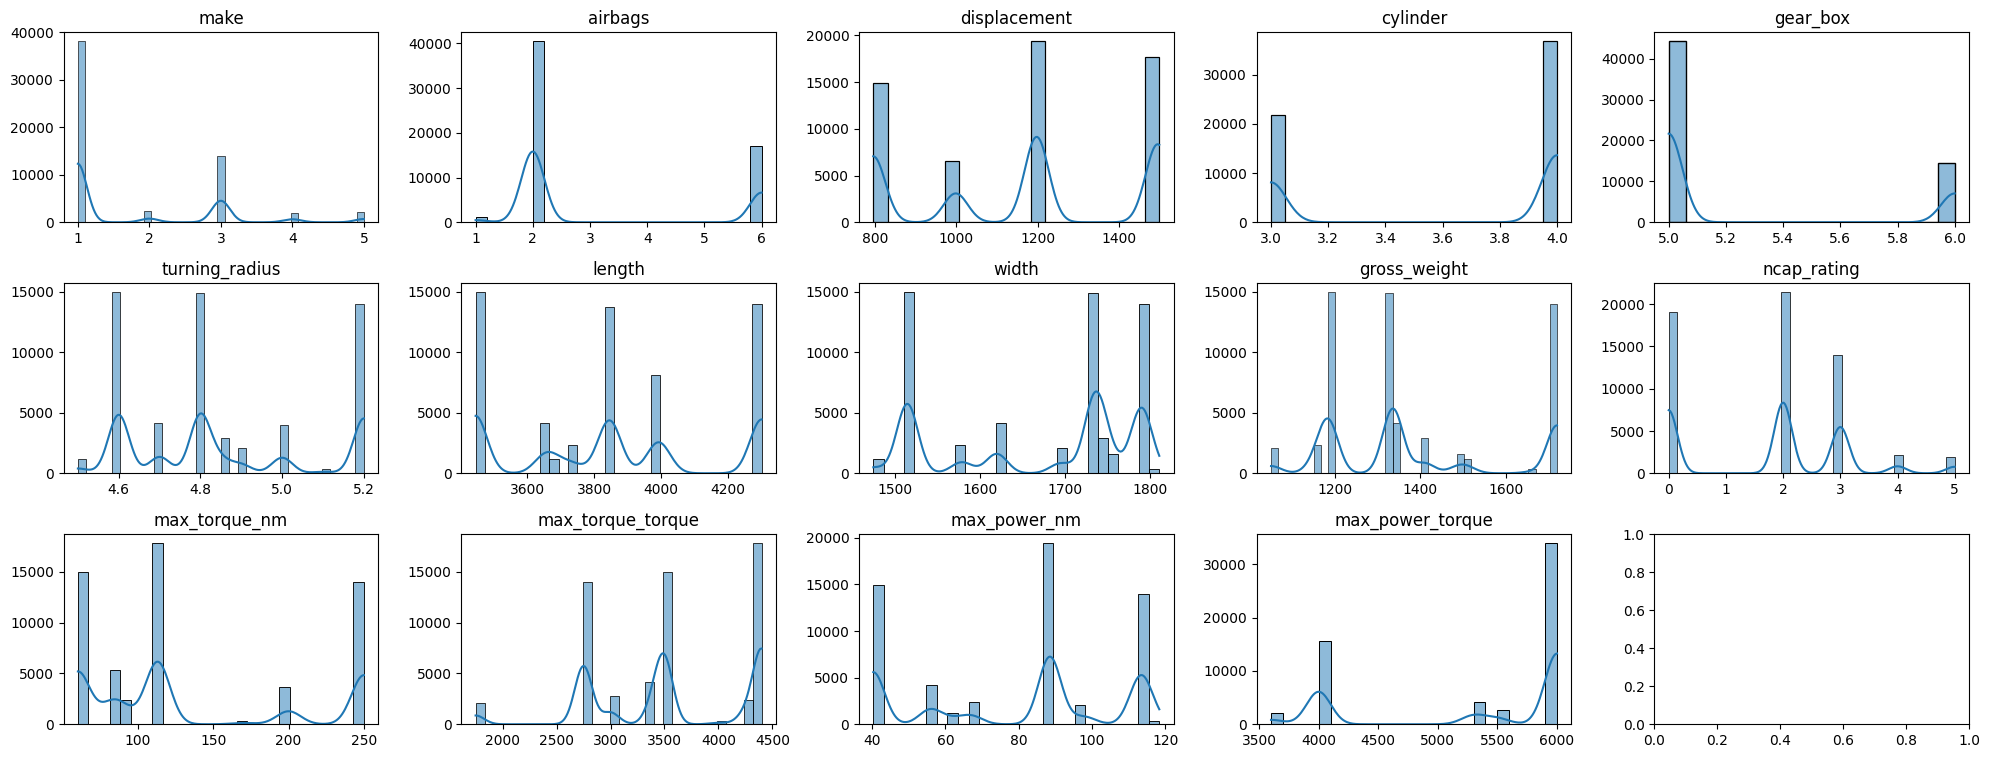

In [16]:
# Show histogram plot of descrete feature
fig,axes = plt.subplots(3,5,figsize=(20,8))
for col,ax in zip(descrete_feature,axes.flatten()):
  sns.histplot(data=df,x=col,ax=ax,kde=True)
  ax.set_title(col)
  ax.set_xlabel('')
  ax.set_ylabel('')

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

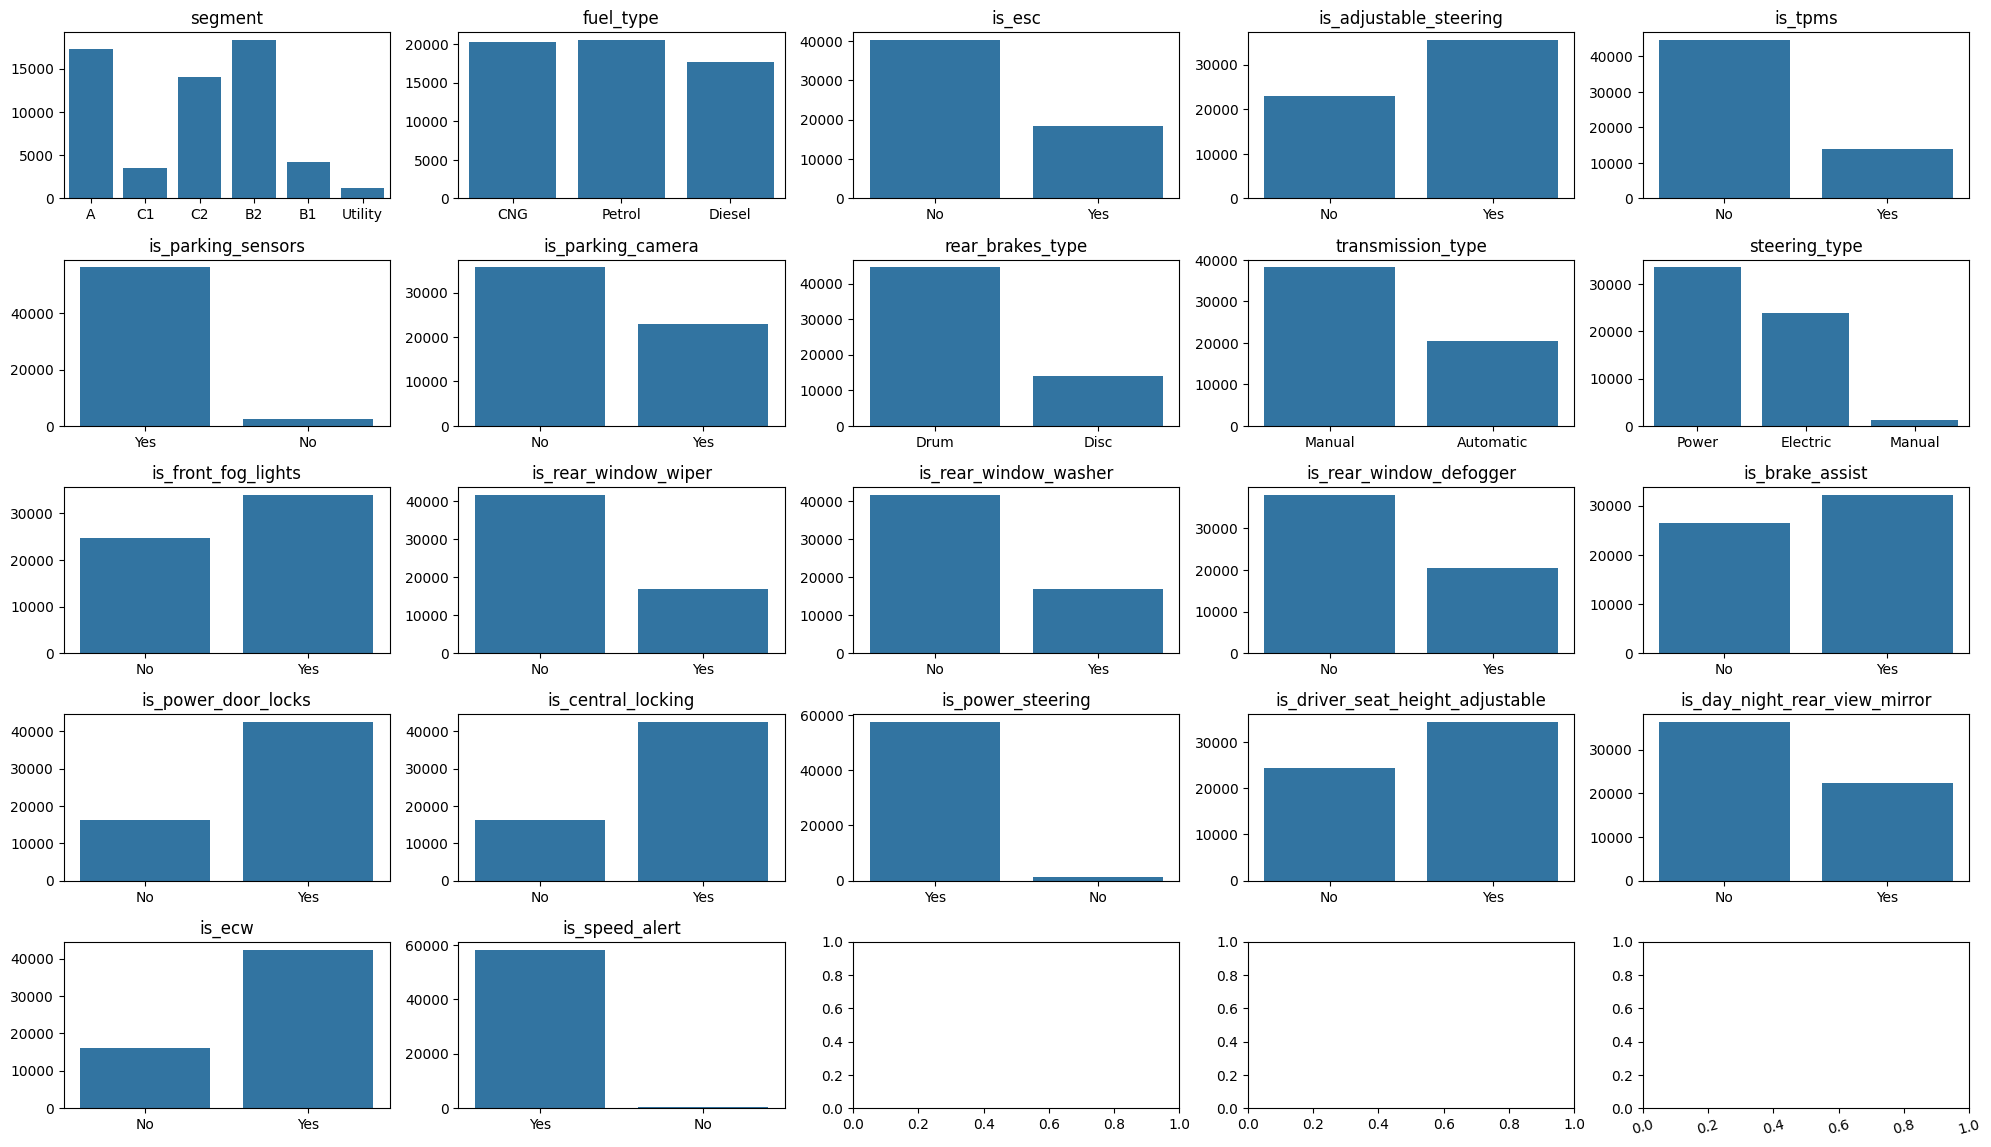

In [17]:
# Show count plot of categorical feature
fig,axes = plt.subplots(5,5,figsize=(20,12))
for col,ax in zip(categorical_feature,axes.flatten()):
  sns.countplot(data=df,x=col,ax=ax)
  ax.set_title(col)
  ax.set_xlabel('')
  ax.set_ylabel('')

plt.tight_layout(rect=[0,0,1,0.96])
plt.xticks(rotation=15)
plt.show()

area_cluster
Cardinality :  22

model
Cardinality :  11

engine_type
Cardinality :  11



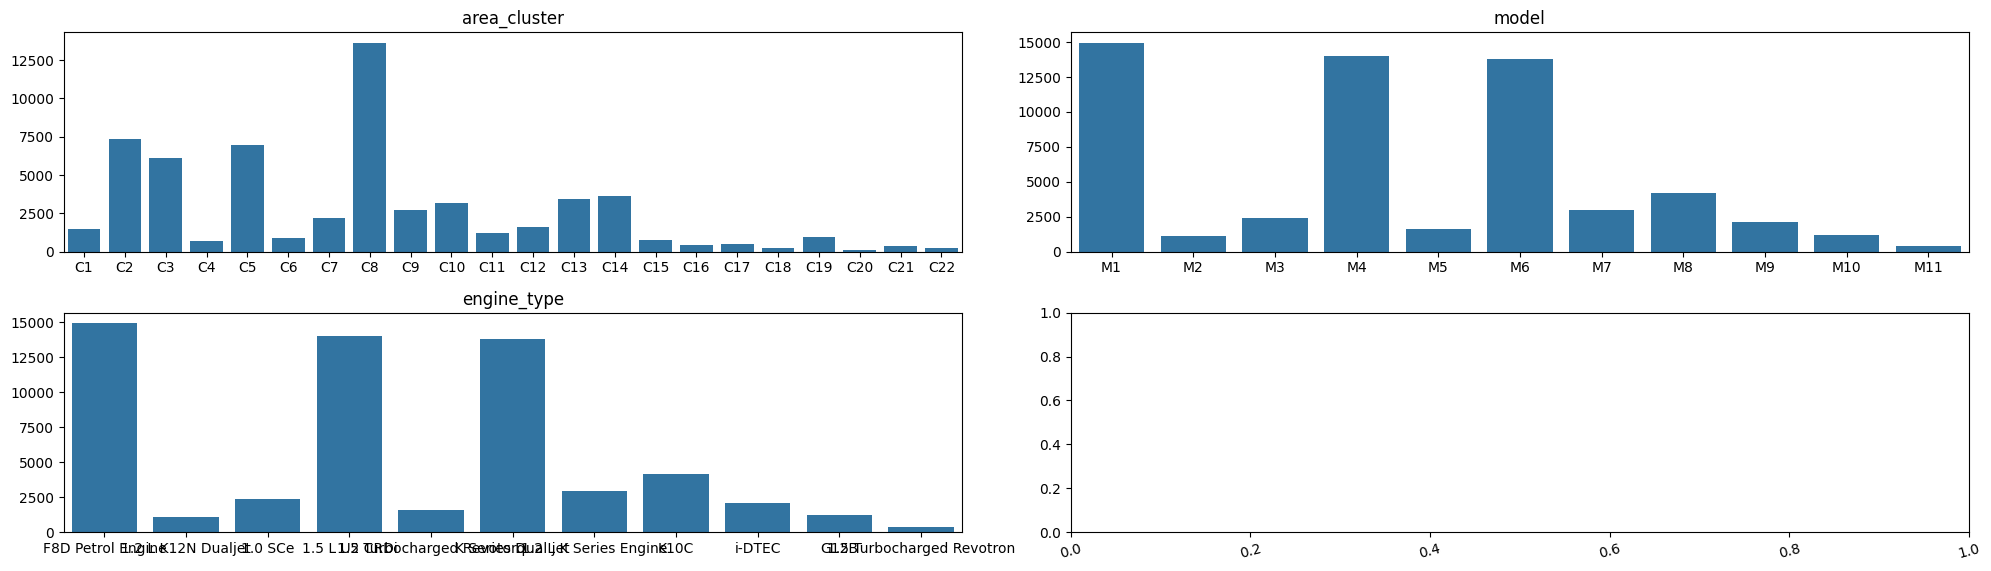

In [18]:
# Show cardinality of categorical features
for feature in cardinal_feature:
  print(feature)
  print('Cardinality : ',df[feature].nunique())
  print()

fig,axes = plt.subplots(2,2,figsize=(20,6))
for col,ax in zip(cardinal_feature,axes.flatten()):
  if df[col].nunique() < 30:
    sns.countplot(data=df,x=col,ax=ax)
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout(rect=[0,0,1,0.96])
plt.xticks(rotation=15)
plt.show()

## Multivariant Analysis

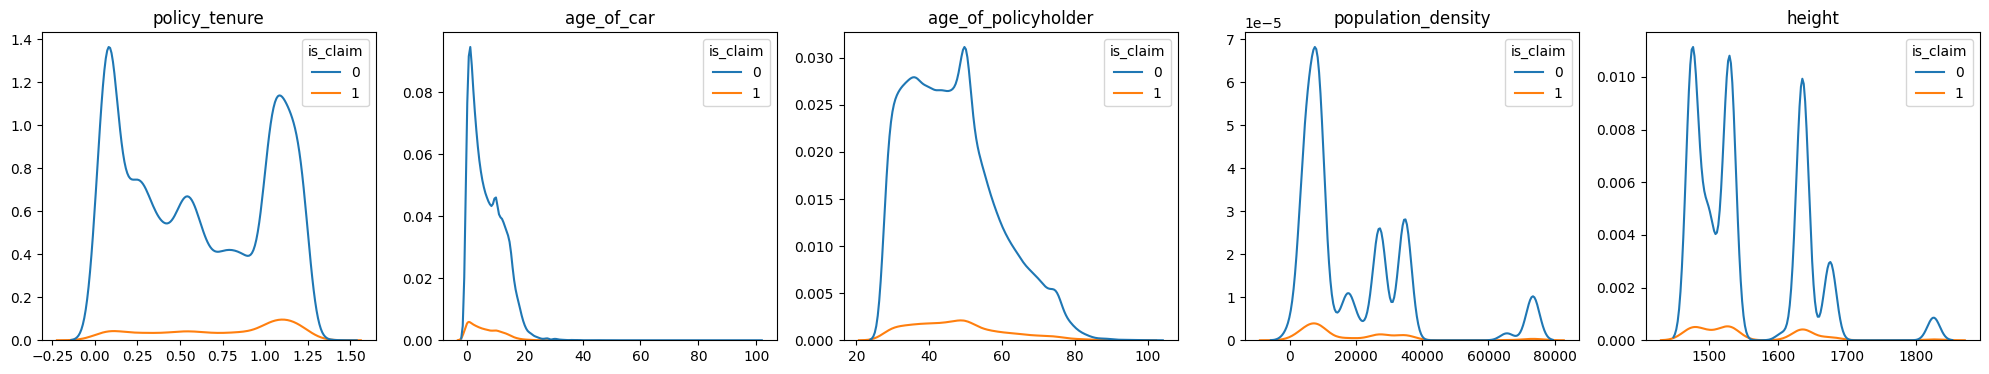

In [19]:
# Show kde plot of continues feature vs target columns (claim Yes or No)

fig,axes = plt.subplots(1,5,figsize=(20,4))
for col,ax in zip(continues_feature,axes.flatten()):
  sns.kdeplot(data=df,x=col,ax=ax,hue=target_feature)
  ax.set_title(col)
  ax.set_xlabel('')
  ax.set_ylabel('')

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

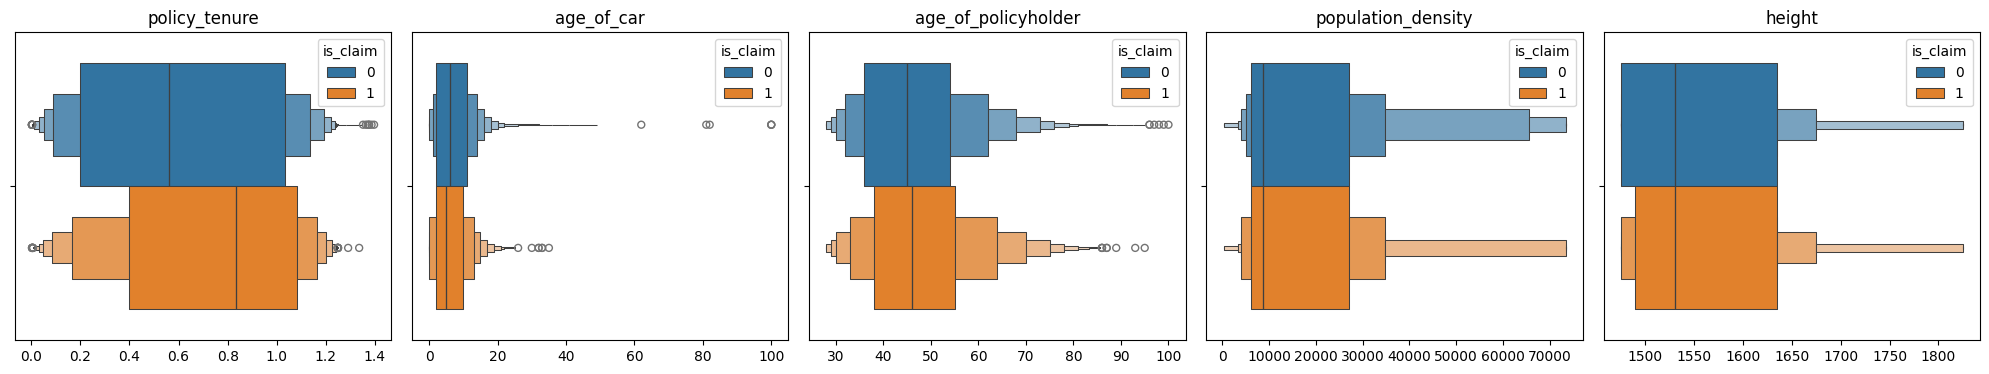

In [20]:
# Show box plot of continues feature vs target columns (claim Yes or No)

fig,axes = plt.subplots(1,5,figsize=(20,4))
for col,ax in zip(continues_feature,axes.flatten()):
  sns.boxenplot(data=df,x=col,ax=ax,hue=target_feature)
  ax.set_title(col)
  ax.set_xlabel('')
  ax.set_ylabel('')

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

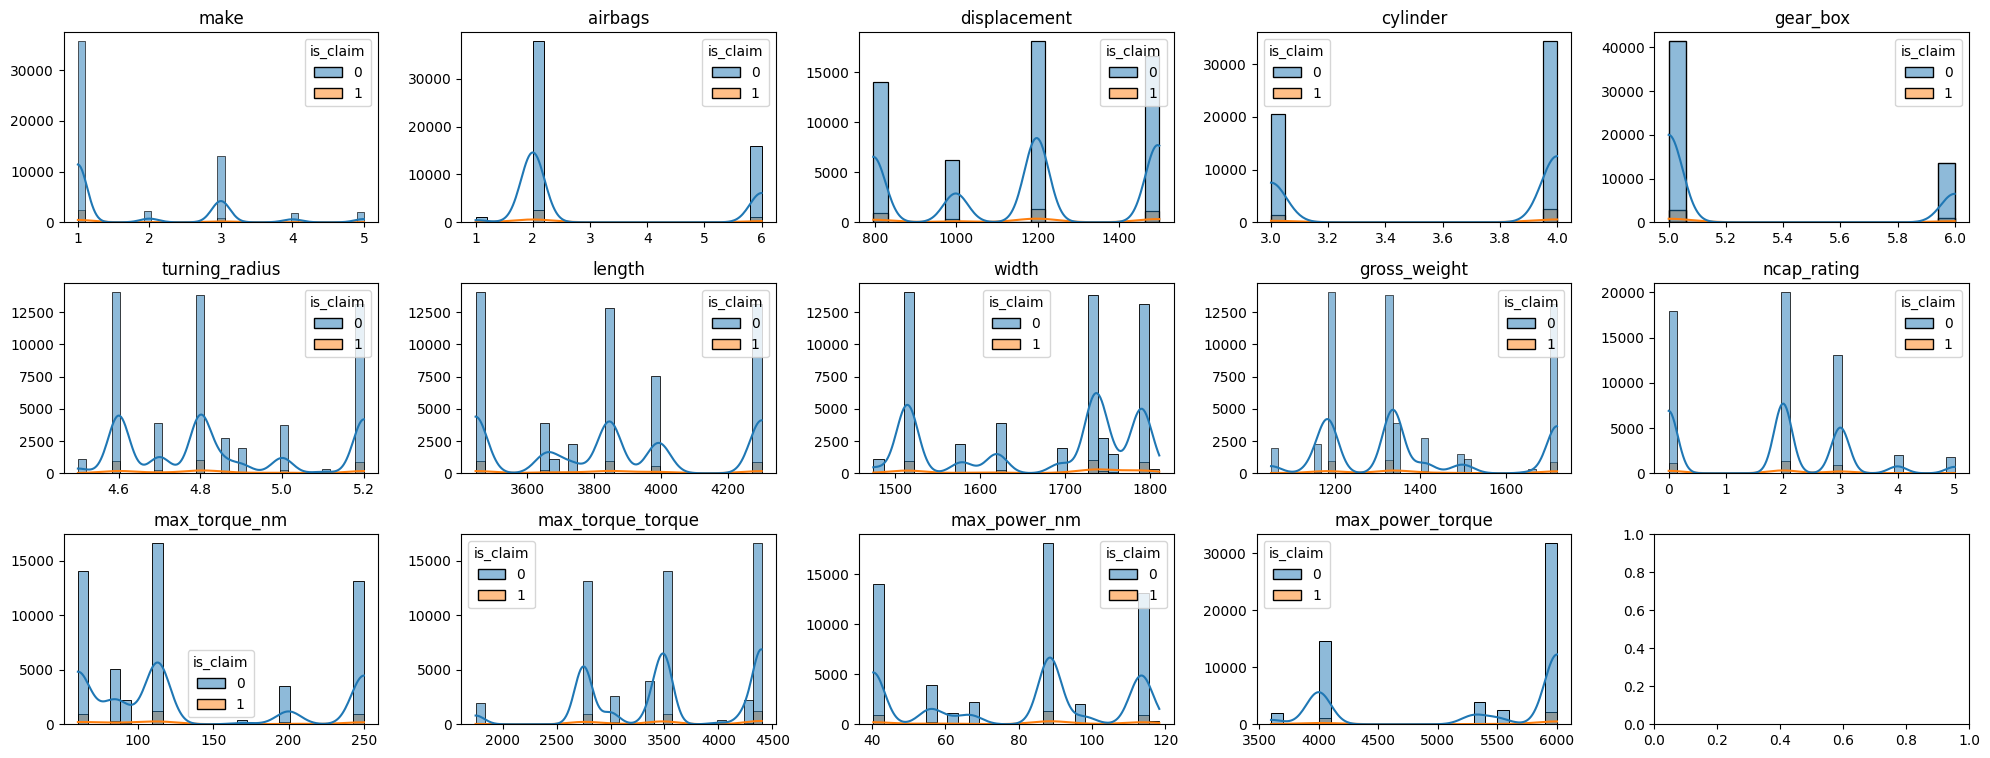

In [21]:
# Show histogram plot of descrete feature vs target columns (claim Yes or No)

fig,axes = plt.subplots(3,5,figsize=(20,8))
for col,ax in zip(descrete_feature,axes.flatten()):
  sns.histplot(data=df,x=col,ax=ax,kde=True,hue=target_feature)
  ax.set_title(col)
  ax.set_xlabel('')
  ax.set_ylabel('')

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

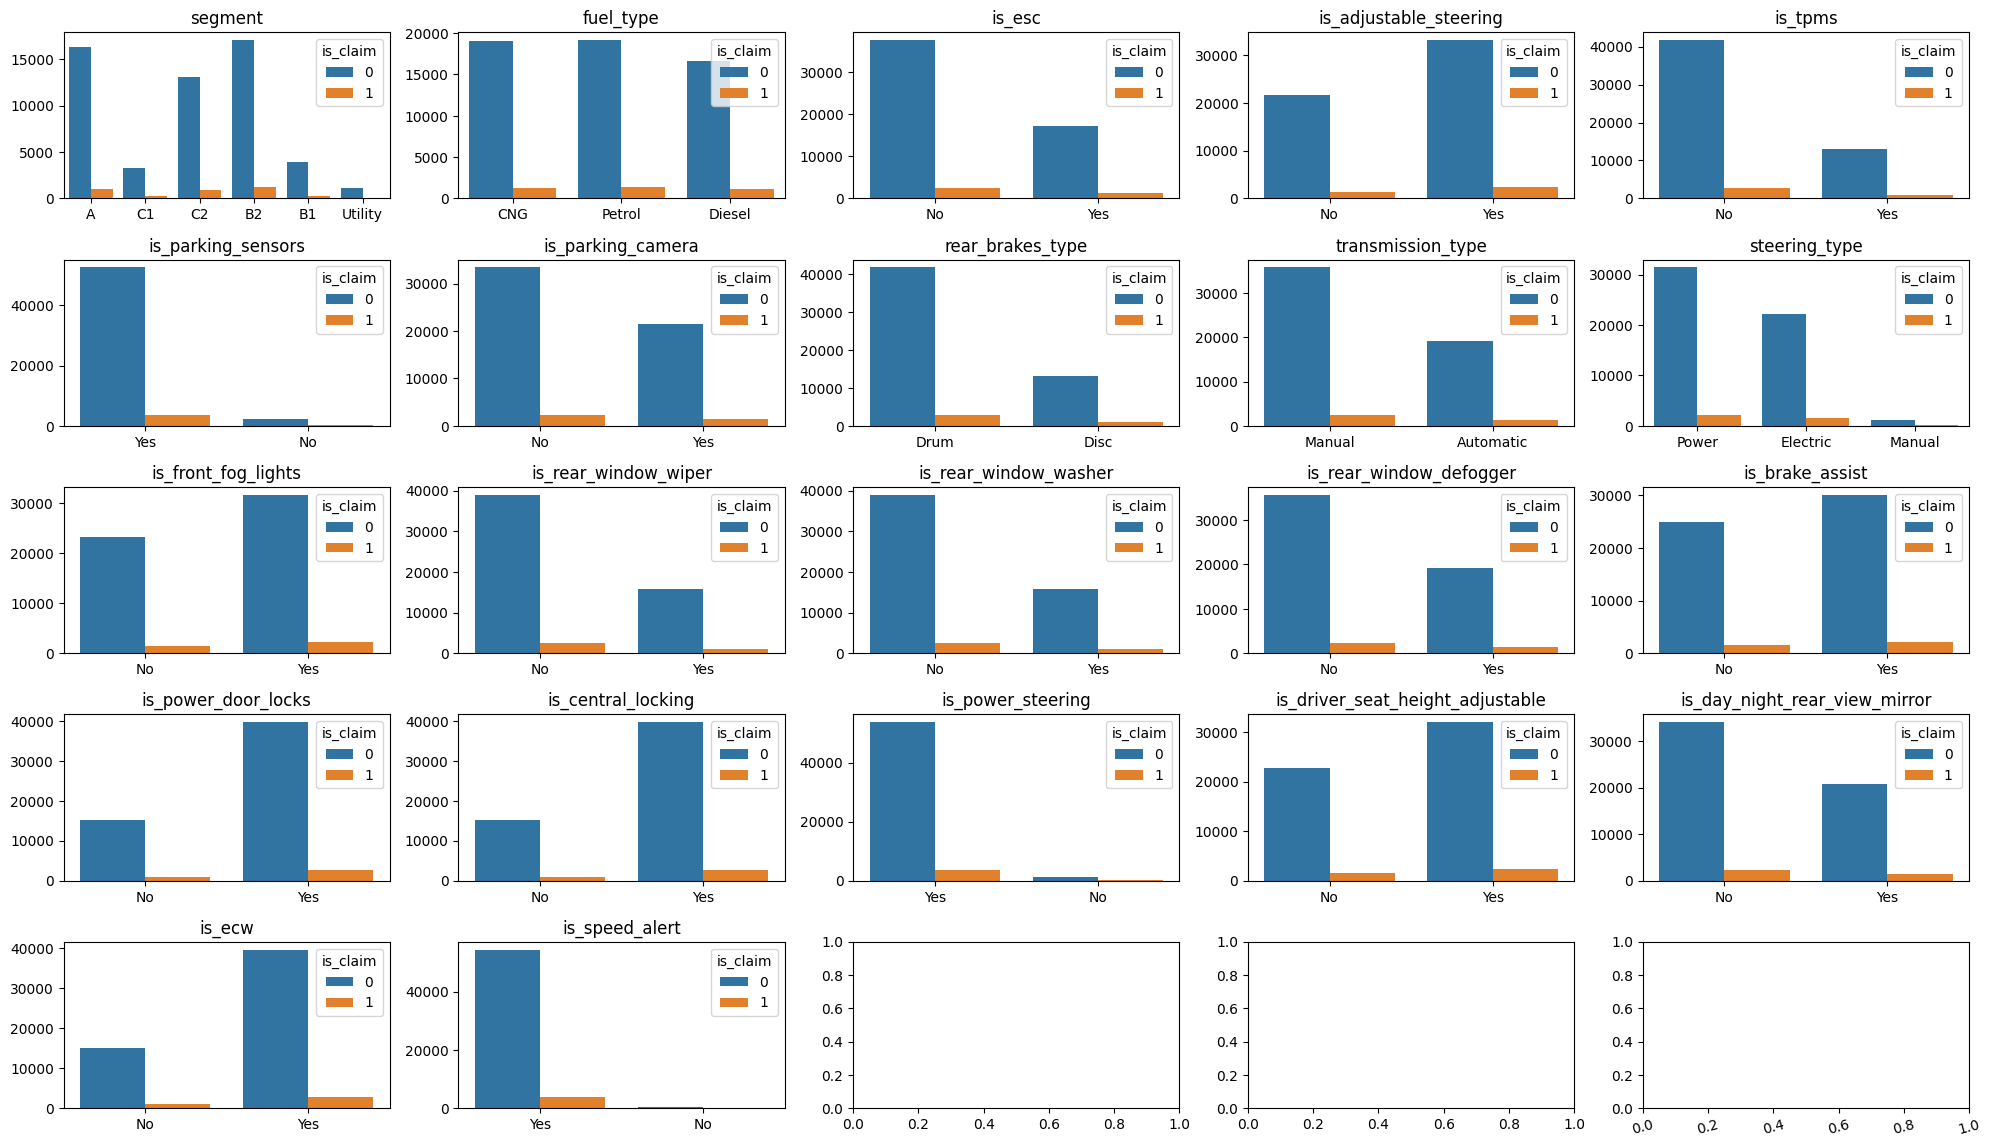

In [22]:
# Show count plot of categorical feature vs target columns (claim Yes or No)

fig,axes = plt.subplots(5,5,figsize=(20,12))
for col,ax in zip(categorical_feature,axes.flatten()):
  sns.countplot(data=df,x=col,ax=ax,hue=target_feature)
  ax.set_title(col)
  ax.set_xlabel('')
  ax.set_ylabel('')

plt.tight_layout(rect=[0,0,1,0.96])
plt.xticks(rotation=15)
plt.show()

In [23]:
claim_data = df.query("is_claim == 1")

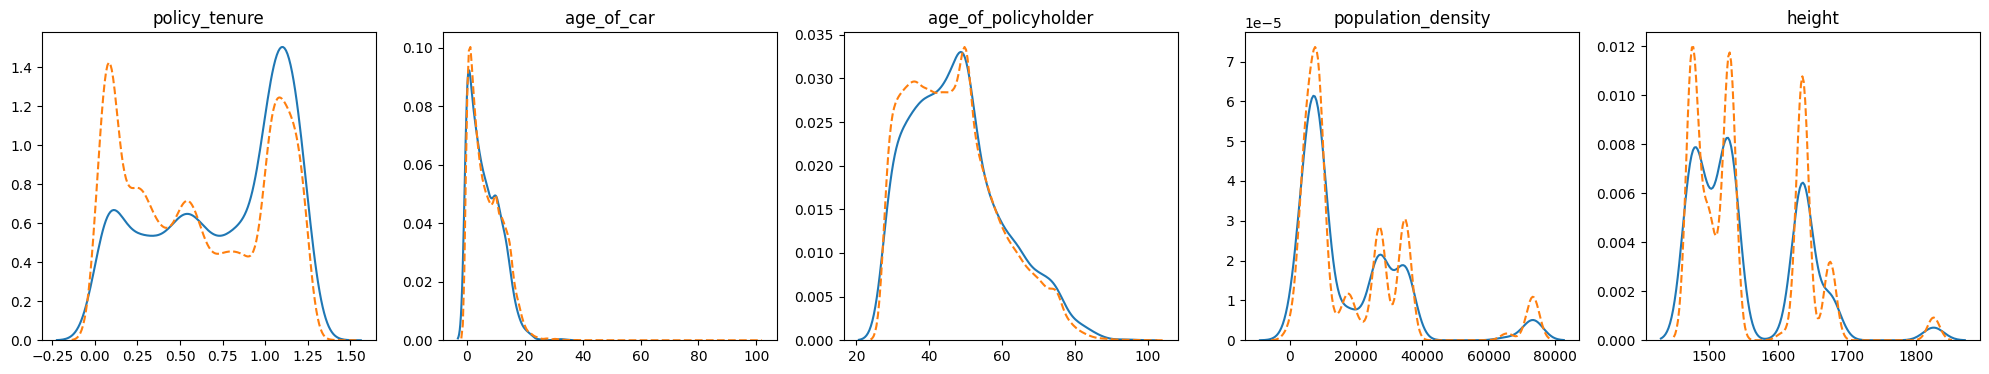

In [24]:
# checking if there is change in distribution between claim (Yes) continues vs  Claim (No) continues
fig,axes = plt.subplots(1,5,figsize=(20,4))
for col,ax in zip(continues_feature,axes.flatten()):
  sns.kdeplot(data=claim_data,x=col,ax=ax)
  sns.kdeplot(data=df,x=col,ax=ax,ls='--')
  ax.set_title(col)
  ax.set_xlabel('')
  ax.set_ylabel('')

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

## Feature Selection

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


import statsmodels.api as sm
from scipy.stats import chi2_contingency,f_oneway,ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [26]:
# Chi Square test for two association between target and independent categorical features
# H0 : feature are independent (no association)
# H1 : feature are dependent (association)
# alpha : 0.05 confidence-l : 0.95%


for feature in categorical_feature + cardinal_feature[1:]:
  chi2, pval, _, _  = chi2_contingency(pd.crosstab(df[feature],df[target_feature]))
  print(f"Feature : {feature:{20}} Result : {f'Reject H0 (Associated, p-value:{pval}) **' if pval < 0.05 else 'Accept H0 (Not Assciated) --'}" )
  if pval < 0.05:
    features_to_select.append(feature)
  else:
    features_to_drop.append(feature)


Feature : segment              Result : Reject H0 (Associated, p-value:0.02738747673628079) **
Feature : fuel_type            Result : Accept H0 (Not Assciated) --
Feature : is_esc               Result : Accept H0 (Not Assciated) --
Feature : is_adjustable_steering Result : Reject H0 (Associated, p-value:0.0008041954126638532) **
Feature : is_tpms              Result : Accept H0 (Not Assciated) --
Feature : is_parking_sensors   Result : Reject H0 (Associated, p-value:0.046026600078480424) **
Feature : is_parking_camera    Result : Accept H0 (Not Assciated) --
Feature : rear_brakes_type     Result : Accept H0 (Not Assciated) --
Feature : transmission_type    Result : Accept H0 (Not Assciated) --
Feature : steering_type        Result : Accept H0 (Not Assciated) --
Feature : is_front_fog_lights  Result : Reject H0 (Associated, p-value:0.004438415801344458) **
Feature : is_rear_window_wiper Result : Accept H0 (Not Assciated) --
Feature : is_rear_window_washer Result : Accept H0 (Not Asscia

In [27]:
# ttest_ind to check if the mean of 2 class (1 & 0) are equal or not equal for all numerical features.
#  H0: the means of the samples are equal.
#  H1: the means of the samples are unequal.
# alpha : 0.05 confidence-l : 0.95%

groups = list()
for feature in descrete_feature + continues_feature:
  group = list()
  for cat in df[target_feature].unique():
    group = [value for value,category in zip(df[feature],df[target_feature]) if category == cat]
    groups.append(group)

  f_statistic, p_value = ttest_ind(*groups)
  print(f"Feature : {feature:{20}} Result : {f'Reject H0 (Not equal, p-value:{p_value}) **' if p_value < 0.05 else f'Accept H0 (Not equal, p-value:{p_value})'}" )
  if p_value < 0.05:
     features_to_select.append(feature)
  else:
    features_to_drop.append(feature)
  groups = list()

Feature : make                 Result : Accept H0 (Not equal, p-value:0.9121488360536878)
Feature : airbags              Result : Accept H0 (Not equal, p-value:0.4996526755376429)
Feature : displacement         Result : Accept H0 (Not equal, p-value:0.06310215766252036)
Feature : cylinder             Result : Reject H0 (Not equal, p-value:0.0011468318451899853) **
Feature : gear_box             Result : Accept H0 (Not equal, p-value:0.8777616296673278)
Feature : turning_radius       Result : Accept H0 (Not equal, p-value:0.5096346505223106)
Feature : length               Result : Accept H0 (Not equal, p-value:0.11594199374360714)
Feature : width                Result : Reject H0 (Not equal, p-value:0.01605028483903441) **
Feature : gross_weight         Result : Accept H0 (Not equal, p-value:0.3458577870636529)
Feature : ncap_rating          Result : Accept H0 (Not equal, p-value:0.35766647542929053)
Feature : max_torque_nm        Result : Accept H0 (Not equal, p-value:0.298615421831085

In [28]:
# Splittig the data into (Train,Test,Val)

X,y = df.drop(target_feature,axis=1),df[target_feature]

X_train, X_other, y_train, y_other = train_test_split(X,y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y_other)

print('Traning data: ',X_train.shape,'Testing data : ',X_test.shape,'Validation data : ',X_val.shape)

Traning data:  (46873, 44) Testing data :  (2344, 44) Validation data :  (9375, 44)


In [29]:
# Creating copy data for feature significance
processed_train = X_train.drop(features_to_drop,axis=1).copy()

In [30]:
# seperating features name based on there data type

selected_df_cat  = processed_train\
                    .select_dtypes(include='object')\
                    .columns.to_list()
selected_df_num  = processed_train\
                    .select_dtypes(exclude='object')\
                    .columns.to_list()

In [31]:
# Appling one hot encoding

processed_train = pd.get_dummies(data=processed_train,
                             columns=selected_df_cat,
                             drop_first=True,
                             dtype=int)

In [32]:
# Applying min max scaler

scaler = MinMaxScaler()

processed_train[selected_df_num[:-1]] = scaler.fit_transform(processed_train[selected_df_num[:-1]])

In [33]:
# Applying Logit (Logistic regressor model) for feature significance (P-value < 0.05).

mod = sm.Logit(y_train,processed_train[selected_df_num[:-1]]).fit(method='minimize',maxiter=100)
print(mod.summary())

Optimization terminated successfully.
         Current function value: 0.272917
         Iterations: 54
         Function evaluations: 55
         Gradient evaluations: 55
                           Logit Regression Results                           
Dep. Variable:               is_claim   No. Observations:                46873
Model:                          Logit   Df Residuals:                    46868
Method:                           MLE   Df Model:                            4
Date:                Sat, 09 Nov 2024   Pseudo R-squ.:                 -0.1480
Time:                        08:38:33   Log-Likelihood:                -12792.
converged:                       True   LL-Null:                       -11143.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
policy_tenure       

In [34]:
# Checking VIF score amoung dependent numerical features for multicolinearity

vif =  pd.DataFrame()
vif['Features'] = processed_train[selected_df_num[:-1]].columns
vif['VIF'] = [variance_inflation_factor(processed_train[selected_df_num[:-1]].values,i) for i in range(processed_train[selected_df_num[:-1]].shape[1])]
vif['VIF'] = round(vif["VIF"], 2)
vif = vif.sort_values(by = "VIF", ascending=False)
vif

,Features,VIF
4,cylinder,2.96
0,policy_tenure,2.95
1,age_of_car,2.77
2,age_of_policyholder,2.61
3,population_density,1.72


In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [38]:
models_dict = {'LogisticR':LogisticRegression,
               'BernoulliNB':BernoulliNB,
               'RandomFC':RandomForestClassifier,
               'GradientBC':GradientBoostingClassifier,
               'AdaBC':AdaBoostClassifier
               }

models_performance = {
                      'Models':list(),
                      'CV_Score':list()
                      }

for model_name,model in models_dict.items():
  scores = cross_val_score(model(),processed_train,y_train,cv=5,scoring='roc_auc')
  print(model_name,f'Roc_auc :',round(np.mean(scores),3))
  models_performance['Models'].append(model_name)
  models_performance['CV_Score'].append(round(np.mean(scores),3))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LogisticR Roc_auc : 0.602
BernoulliNB Roc_auc : 0.548
RandomFC Roc_auc : 0.561
GradientBC Roc_auc : 0.652
AdaBC Roc_auc : 0.633


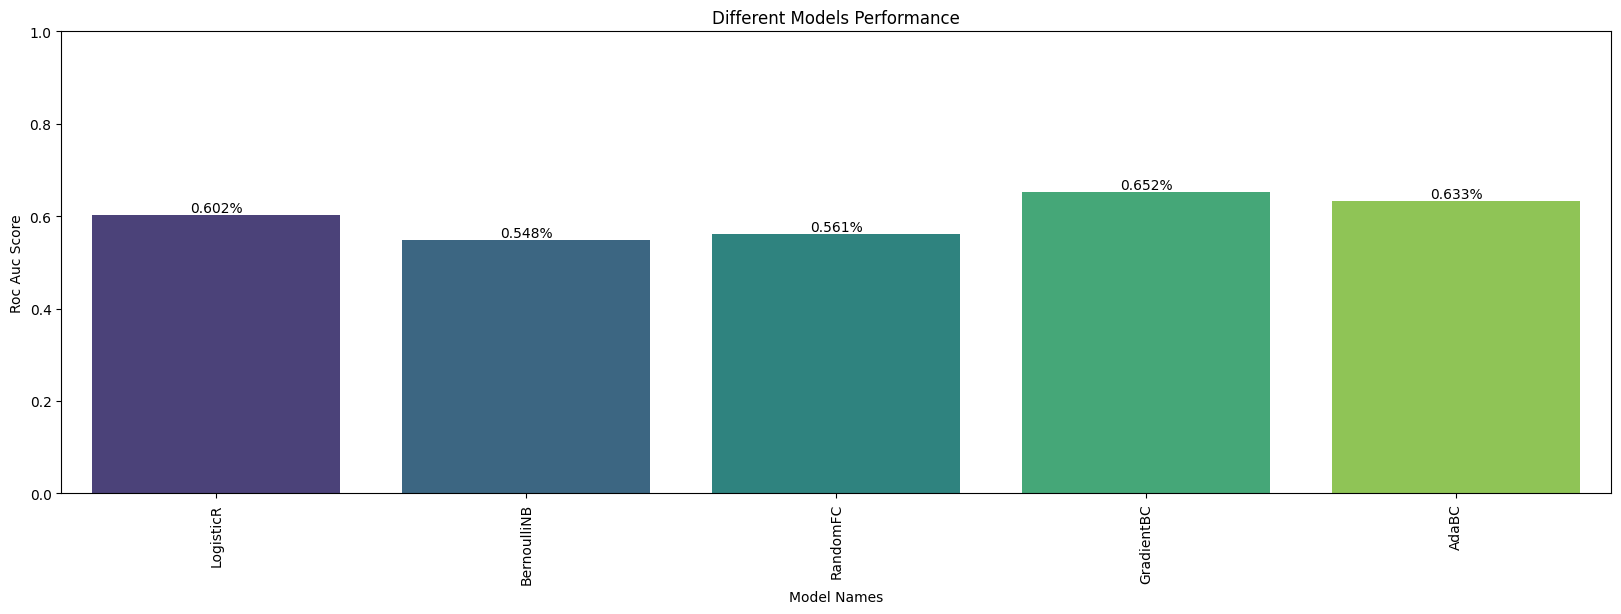

In [39]:
plt.figure(figsize=(20, 6))
bar_plot = sns.barplot(x='Models', y='CV_Score',
                       data=models_performance, palette='viridis')

# Add title and labels
plt.title('Different Models Performance')
plt.xlabel('Model Names')
plt.ylabel('Roc Auc Score')
plt.xticks(rotation=90)
plt.ylim((0,1))

# Add percentage labels on top of each bar
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height()}%',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='bottom', fontsize=10)

# Show the plot
plt.show()

## Handling Imbalance data

In [41]:
from imblearn.over_sampling import SMOTE

In [42]:
smt = SMOTE(
    sampling_strategy='auto',  # samples only the minority class
    random_state=0,  # for reproducibility
    k_neighbors=5,
)

X_res, y_res = smt.fit_resample(processed_train,y_train)

In [43]:
X_res.shape,processed_train.shape

((87750, 57), (46873, 57))

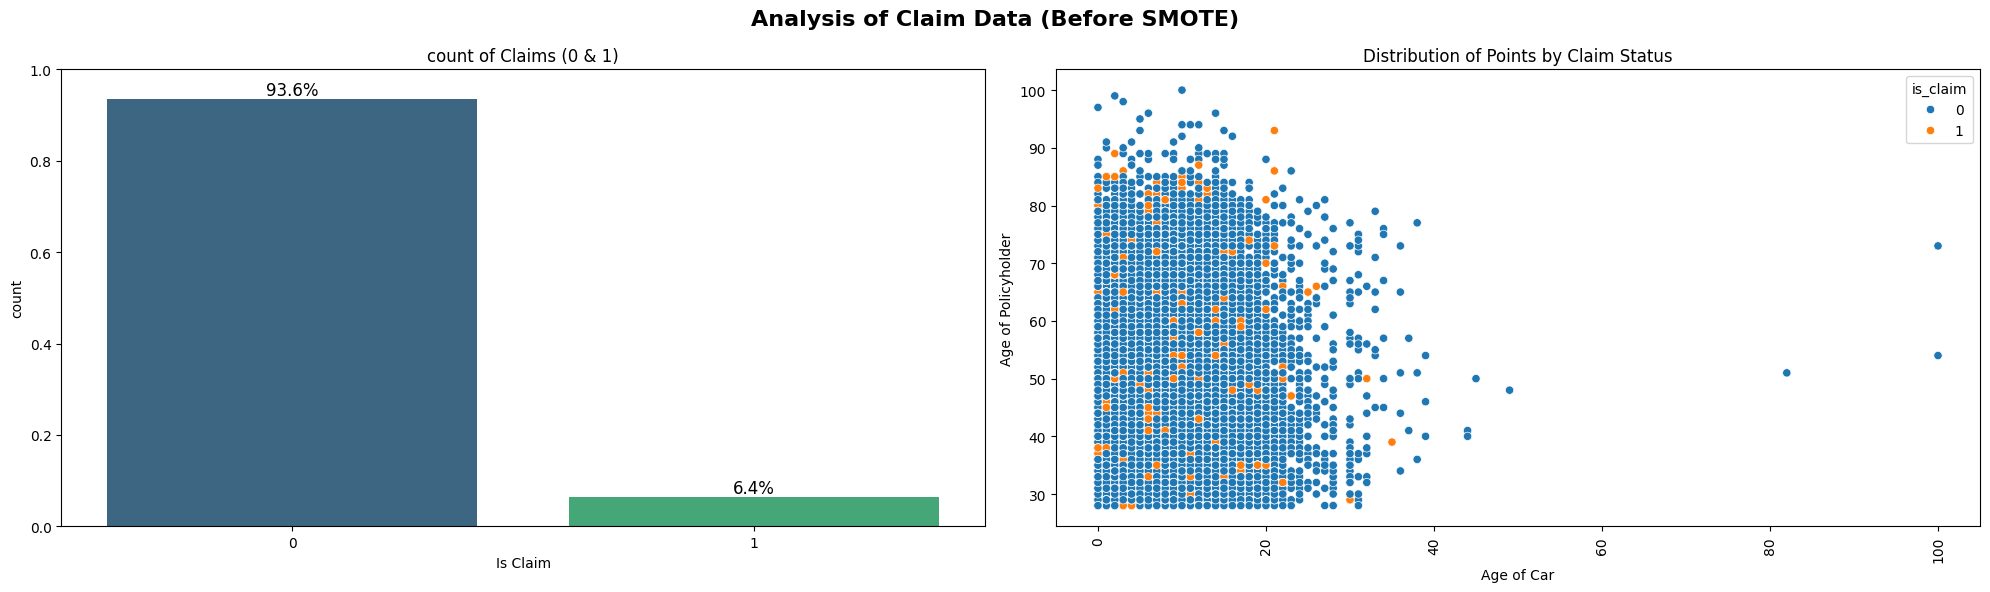

In [63]:
# Generate count data for plotting
count_data = y_train.value_counts(normalize=True).reset_index()
count_data.columns = ['is_claim', 'count']

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# Add a title for the entire figure
fig.suptitle('Analysis of Claim Data (Before SMOTE)', fontsize=16, fontweight='bold')

# First plot: Bar plot showing the count of claims (0 & 1)
bar_plot = sns.barplot(x='is_claim', y='count', data=count_data, palette='viridis', ax=ax[0])

# Add title and labels
ax[0].set_title('count of Claims (0 & 1)')
ax[0].set_xlabel('Is Claim')
ax[0].set_ylabel('count')
ax[0].set_xticks([0, 1])
ax[0].set_ylim(0, 1)  # Set the y-axis to show counts

# Add count labels on top of each bar
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height()*100:.1f}%',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='bottom', fontsize=12)

# Second plot: Scatter plot to show the distribution of 'age_of_car' vs 'age_of_policyholder' based on 'is_claim'
sns.scatterplot(data=pd.concat([X_train, y_train], axis=1),
                x='age_of_car',
                y='age_of_policyholder',
                hue='is_claim',
                ax=ax[1])

# Add titles and labels for the scatter plot
ax[1].set_title('Distribution of Points by Claim Status')
ax[1].set_xlabel('Age of Car')
ax[1].set_ylabel('Age of Policyholder')
ax[1].tick_params(axis='x', rotation=90)  # Rotate x-ticks if necessary

# Show the plot
plt.tight_layout()
plt.show()


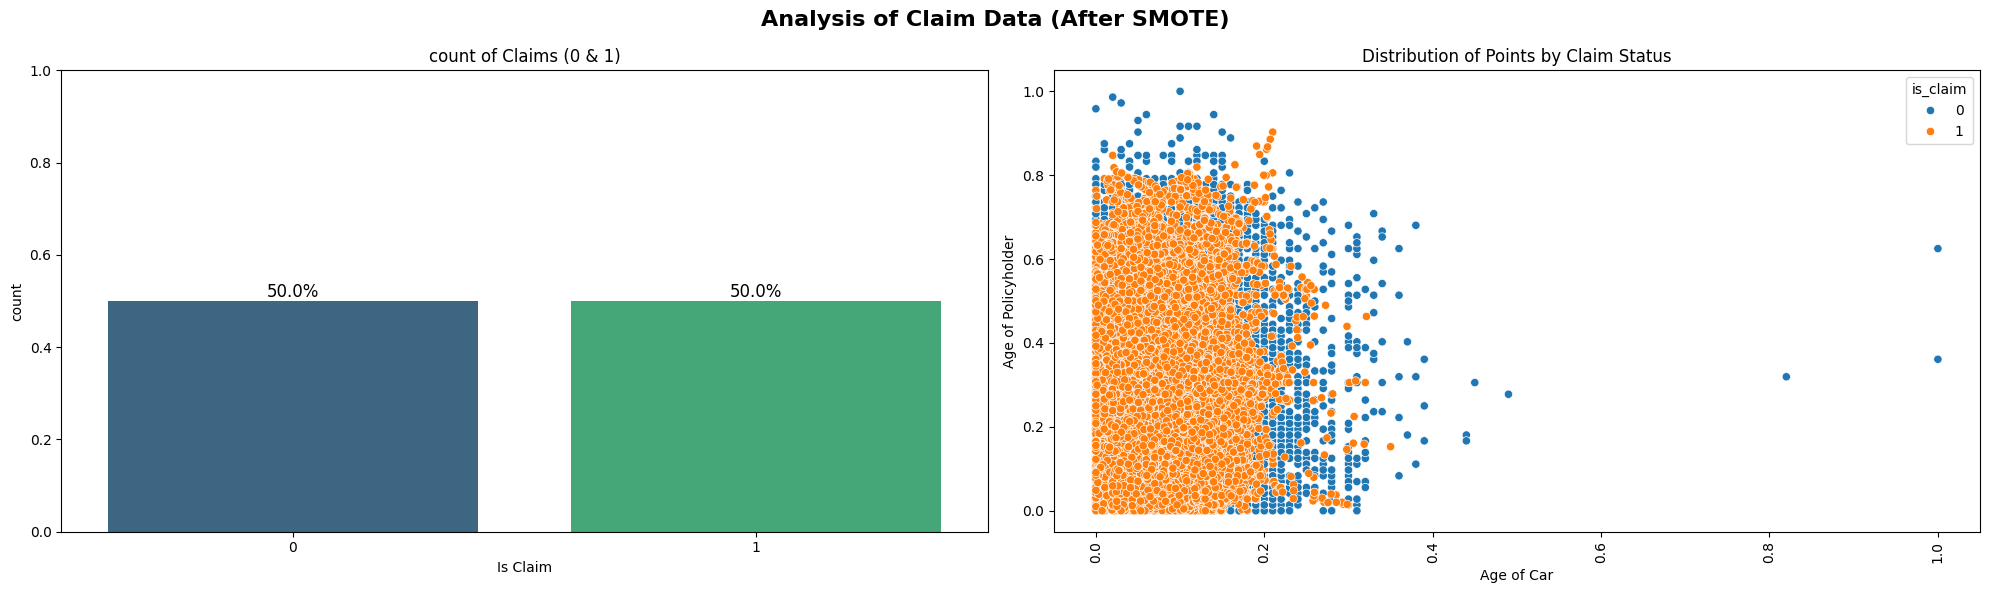

In [64]:
# Generate count data for plotting
count_data = y_res.value_counts(normalize=True).reset_index()
count_data.columns = ['is_claim', 'count']

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# Add a title for the entire figure
fig.suptitle('Analysis of Claim Data (After SMOTE)', fontsize=16, fontweight='bold')


# First plot: Bar plot showing the count of claims (0 & 1)
bar_plot = sns.barplot(x='is_claim', y='count', data=count_data, palette='viridis', ax=ax[0])

# Add title and labels
ax[0].set_title('count of Claims (0 & 1)')
ax[0].set_xlabel('Is Claim')
ax[0].set_ylabel('count')
ax[0].set_xticks([0, 1])
ax[0].set_ylim(0, 1)  # Set the y-axis to show counts

# Add count labels on top of each bar
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height()*100:.1f}%',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='bottom', fontsize=12)

# Second plot: Scatter plot to show the distribution of 'age_of_car' vs 'age_of_policyholder' based on 'is_claim'
sns.scatterplot(data=pd.concat([X_res, y_res], axis=1),
                x='age_of_car',
                y='age_of_policyholder',
                hue='is_claim',
                ax=ax[1])

# Add titles and labels for the scatter plot
ax[1].set_title('Distribution of Points by Claim Status')
ax[1].set_xlabel('Age of Car')
ax[1].set_ylabel('Age of Policyholder')
ax[1].tick_params(axis='x', rotation=90)  # Rotate x-ticks if necessary

# Show the plot
plt.tight_layout()
plt.show()


In [46]:
models_dict = {'LogisticR':LogisticRegression,
               'BernoulliNB':BernoulliNB,
               'RandomFC':RandomForestClassifier,
               'GradientBC':GradientBoostingClassifier,
               'AdaBC':AdaBoostClassifier
               }

models_performance = {
                      'Models':list(),
                      'CV_Score':list()
                      }

for model_name,model in models_dict.items():
  scores = cross_val_score(model(),X_res, y_res,cv=5,scoring='roc_auc')
  print(model_name,f'Roc_auc :',round(np.mean(scores),3))
  models_performance['Models'].append(model_name)
  models_performance['CV_Score'].append(round(np.mean(scores),3))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LogisticR Roc_auc : 0.62
BernoulliNB Roc_auc : 0.554
RandomFC Roc_auc : 0.968
GradientBC Roc_auc : 0.948
AdaBC Roc_auc : 0.789


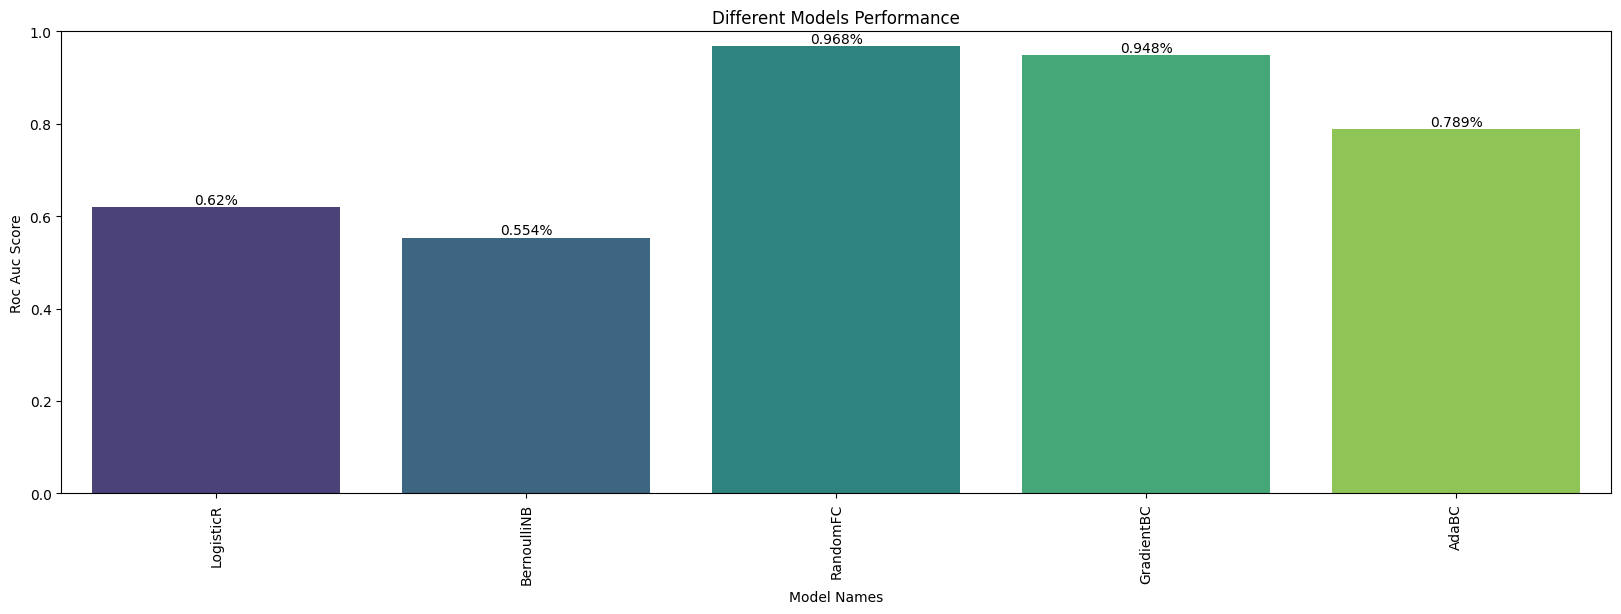

In [47]:
plt.figure(figsize=(20, 6))
bar_plot = sns.barplot(x='Models', y='CV_Score',
                       data=models_performance, palette='viridis')

# Add title and labels
plt.title('Different Models Performance')
plt.xlabel('Model Names')
plt.ylabel('Roc Auc Score')
plt.xticks(rotation=90)
plt.ylim((0,1))

# Add percentage labels on top of each bar
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height()}%',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='bottom', fontsize=10)

# Show the plot
plt.show()

# Fine Tuning

In [65]:
!pip install feature-engine --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.0/375.0 kB 5.4 MB/s eta 0:00:00


In [ ]:
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

# Ensure features_to_drop is defined somewhere before this part of the code
# Example: features_to_drop = ['feature1', 'feature2', ...]

cat_features = X_train.drop(features_to_drop, axis=1).select_dtypes(include='object').columns.to_list()
num_features = X_train.drop(features_to_drop, axis=1).select_dtypes(exclude='object').columns.to_list()

# Creating the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(dtype=int, drop='first'), cat_features),
        ('num', MinMaxScaler(), num_features)
    ],
    remainder='passthrough'  # Keep other columns as they are
)

X_train_transformed = preprocessor.fit_transform(X_train.drop(features_to_drop,axis=1))
smote = SMOTE(random_state=42)
classifier = RandomForestClassifier()


# Define the pipeline
pipeline = make_pipeline(smote,classifier)

# Parameter grid for GridSearchCV
param_grid = [
    {
        'smote__k_neighbors': [3, 5, 7],
        # 'classifier__n_estimators': [50, 75, 100, 150, 200],
        # 'classifier__min_samples_split': [0.1, 0.2, 0.3],
        # 'classifier__max_features': ['sqrt', 'log2']
    }
]

# Setup GridSearchCV with cross-validation (cv=10) and parallel execution (n_jobs=-1)
grid_search = GridSearchCV(pipeline, param_grid, cv=10, verbose=1, n_jobs=-1)

# Fit the model to training data, making sure features_to_drop is defined correctly
grid_search.fit(X_train_transformed, y_train)

# View the best parameters and the corresponding score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")


Fitting 10 folds for each of 3 candidates, totalling 30 fits
